In [36]:
import pandas as pd
import numpy as np
from scipy import stats
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectFromModel, RFE
from sklearn.model_selection import GridSearchCV
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from imblearn.over_sampling import ADASYN
from imblearn.combine import SMOTEENN
from pandas.plotting import table
import re
from statsmodels.api import OLS
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectFromModel, RFE
from sklearn.model_selection import GridSearchCV
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from imblearn.over_sampling import ADASYN
from imblearn.combine import SMOTEENN
from pandas.plotting import table
import re
from statsmodels.api import OLS        
from sklearn.utils import resample
from sklearn.metrics import (roc_auc_score, roc_curve, confusion_matrix, 
                             classification_report, accuracy_score, confusion_matrix, 
                             classification_report, precision_score, recall_score,f1_score)

In [ ]:

def _compute_midrank(x):
    """Calculaí-se o rank médio de cada valor em x."""
    sorted_idx = np.argsort(x)
    ranks = np.empty_like(sorted_idx, dtype=float)
    ranks[sorted_idx] = np.arange(len(x))
    # Identifica elementos iguais
    unique_vals, first_idx, counts = np.unique(x, return_index=True, return_counts=True)
    midranks = first_idx + (counts - 1) / 2.0
    # Atribui ranks médios
    for val, mid in zip(unique_vals, midranks):
        ranks[x == val] = mid
    return ranks

def delong_roc_variance(labels, scores):
    """Estima a AUC e a sua variância segundo DeLong."""
    # Separa positivos e negativos
    pos = scores[labels == 1]
    neg = scores[labels == 0]
    m, n = len(pos), len(neg)
    all_scores = np.concatenate([pos, neg])
    ranks = _compute_midrank(all_scores)
    r_pos = ranks[:m]
    r_neg = ranks[m:]
    # Cálculo da AUC
    auc = (np.sum(r_pos) - m*(m+1)/2) / (m*n)
    # Componentes de variância
    v10 = (r_pos - (m+1)/2) / n
    v01 = 1 - (r_neg - (n+1)/2) / m
    var_auc = (np.var(v10, ddof=1) / m) + (np.var(v01, ddof=1) / n)
    return auc, var_auc

def delong_roc_test(labels, scores1, scores2):
    """Compara-se duas AUC através do teste de DeLong, retornando z e p-valor."""
    auc1, var1 = delong_roc_variance(labels, scores1)
    auc2, var2 = delong_roc_variance(labels, scores2)
    # Supõe-se covariância nula para simplificação
    se = np.sqrt(var1 + var2)
    z = (auc1 - auc2) / se
    p_value = stats.norm.sf(abs(z)) * 2
    return auc1, auc2, z, p_value

In [37]:
def bootstrap_metric_confidence_interval(
    y_true,
    y_pred_or_proba,
    metric_func,
    n_bootstraps=1000,
    alpha=0.05,
    random_state=None
):
    """
    Returns (original_estimate, lower_ci, upper_ci) using bootstrapping.

    Parameters:
    -----------
    - y_true : array-like
        True label values.
    - y_pred_or_proba : array-like
        Model predictions:
          * For accuracy, use predicted labels (e.g., 0/1).
          * For AUC, use probabilities (float between 0 and 1) or continuous scores.
    - metric_func : callable
        Metric function, such as accuracy_score or roc_auc_score.
    - n_bootstraps : int
        Number of bootstrap resamples.
    - alpha : float
        Significance level (0.05 corresponds to a 95% confidence interval).
    - random_state : int
        Seed for reproducibility.
    """
    if random_state is not None:
        np.random.seed(random_state)

    n = len(y_true)
    # Calculate original metric
    original_stat = metric_func(y_true, y_pred_or_proba)

    # Perform bootstrap resampling
    stats_boot = []
    for _ in range(n_bootstraps):
        indices = np.random.randint(0, n, n)
        sample_y_true = y_true[indices]
        sample_y_pred_or_proba = y_pred_or_proba[indices]

        stat = metric_func(sample_y_true, sample_y_pred_or_proba)
        stats_boot.append(stat)

    stats_boot = np.sort(stats_boot)
    lower = np.percentile(stats_boot, 100 * (alpha / 2))
    upper = np.percentile(stats_boot, 100 * (1 - alpha / 2))

    return original_stat, lower, upper



In [38]:
# Load the dataset
file_path = 'sars_data_pred_clean.csv'
df = pd.read_csv(file_path, encoding='latin1')

# Remove the variable 'resultado_flu'
df = df.drop(columns=['resultado_influenza'])


In [39]:
class MICEImputer:
    def __init__(self, m=5, max_iter=5, random_state=0):
        self.m = m
        self.max_iter = max_iter
        np.random.seed(random_state)

    def _pmm(self, y, X):
        model = OLS(y, X).fit()
        pred = model.predict(X)
        donors = [np.random.choice(np.argsort(abs(pred - p))[:5]) for p in pred]
        return y[donors]

    def _logit(self, y, X):
        model = LogisticRegression(max_iter=1000).fit(X, y)
        probs = model.predict_proba(X)[:, 1]
        return (np.random.rand(len(probs)) < probs).astype(int)

    def _multi(self, y, X):
        model = LogisticRegression(multi_class='multinomial', max_iter=1000).fit(X, y)
        probs = model.predict_proba(X)
        return np.array([np.random.choice(model.classes_, p=p) for p in probs])

    def _ordinal(self, y, X):
        levels = np.sort(np.unique(y))
        n = len(levels)
        probs = np.zeros((X.shape[0], n))
        for i, lev in enumerate(levels[:-1]):
            bin_y = (y <= lev).astype(int)
            model = LogisticRegression(max_iter=1000).fit(X, bin_y)
            probs[:, i] = model.predict_proba(X)[:, 1]
        probs[:, -1] = 1
        for i in range(n - 1, 0, -1):
            probs[:, i] -= probs[:, i - 1]

        # Corrigir possíveis valores negativos e normalizar
        probs[probs < 0] = 0
        probs = probs / probs.sum(axis=1, keepdims=True)

        return np.array([np.random.choice(levels, p=p) for p in probs])

    def fit_transform(self, df, var_types):
        imputados = []
        for _ in range(self.m):
            temp = df.copy()
            for _ in range(self.max_iter):
                for col in df.columns[df.isna().any()]:
                    miss_idx = temp[col].isna()
                    X_df = pd.get_dummies(temp.drop(columns=[col]), dummy_na=True)
                    valid_X = X_df.dropna()
                    valid_idx = valid_X.index.intersection(temp[~miss_idx].index)
                    y = temp[col].loc[valid_idx]
                    if y.isna().any() or valid_X.loc[valid_idx].isna().any().any():
                        continue
                    X = valid_X.loc[valid_idx].values
                    if var_types[col] == 'numeric':
                        imp = self._pmm(y.values, X)
                    elif var_types[col] == 'binary':
                        imp = self._logit(y.values, X)
                    elif var_types[col] == 'nominal':
                        imp = self._multi(y.values, X)
                    elif var_types[col] == 'ordinal':
                        imp = self._ordinal(y.values, X)
                    temp.loc[miss_idx, col] = np.random.choice(imp, size=miss_idx.sum(), replace=True)
            imputados.append(temp)
        return pd.concat(imputados).groupby(level=0).mean(numeric_only=True)

# use
if __name__ == "__main__":
    df.columns = [re.sub(r'\W|^(?=\d)', '_', c) for c in df.columns]
    df = df.loc[:, df.isna().mean() <= 0.35]

    var_types = {
    'Age_group': 'ordinal', 'Patient_Status': 'ordinal',
    'Weight': 'numeric', 'Respiratory_rate': 'numeric', 'Days_of_symptoms': 'numeric',
    'Sex': 'binary', 'Hospitalization': 'binary', 'SARS_CoV_2_Vaccine': 'binary',
    'Fever': 'binary', 'Cough': 'binary', 'Respiratory_distress': 'binary', 'Myalgia': 'binary',
    'Chills': 'binary', 'Sore_throat': 'binary', 'Rhinorrhea': 'binary', 'Otorrhea_otalgia': 'binary',
    'Nasal_congestion': 'binary', 'Itching': 'binary', 'Chest_pain': 'binary',
    'Weakness': 'binary', 'Joint_pain': 'binary',  'resultado_sars_cov_2': 'binary'
}
    mice = MICEImputer()
    df_imp = mice.fit_transform(df, var_types)

    numericas = [k for k, v in var_types.items() if v == 'numeric']
    df_imp[numericas] = StandardScaler().fit_transform(df_imp[numericas])
    df_imp.to_csv("dados_imputados_sars.csv", index=False)
    print("Imputação concluída com sucesso e guardada em 'dados_imputados_sars.csv'")

Imputação concluída com sucesso e guardada em 'dados_imputados_sars.csv'


In [40]:
# from sklearn.impute import SimpleImputer
# from sklearn.preprocessing import StandardScaler

# Ensure appropriate format for variables
# categorical_cols = df.select_dtypes(include=['object', 'category']).columns
# numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns

# Imputation of missing values for categorical variables
# imputer_cat = SimpleImputer(strategy='most_frequent')
# if len(categorical_cols) > 0:
#    df[categorical_cols] = df[categorical_cols].astype(str)
#    df[categorical_cols] = imputer_cat.fit_transform(df[categorical_cols])

# Imputation of missing values for numerical variables
# imputer_num = SimpleImputer(strategy='mean')
# df[numerical_cols] = imputer_num.fit_transform(df[numerical_cols])


# Colunas que realmente são numéricas contínuas para normalização
# selected_cols = ['Weight', 'Age', 'Respiratory rate']  # Ajuste de acordo com a base de dados disponível

# Verifique se as colunas existem
# existing_selected_cols = [col for col in selected_cols if col in df.columns]

# Aplicar normalização apenas nas variáveis numéricas contínuas
# scaler = StandardScaler()
# df[existing_selected_cols] = scaler.fit_transform(df[existing_selected_cols])


In [41]:
# Define target variable and features
df = pd.read_csv("dados_imputados_sars.csv")
target = 'resultado_sars_cov_2'
X = df.drop(columns=[target])
y = df[target].astype(int)

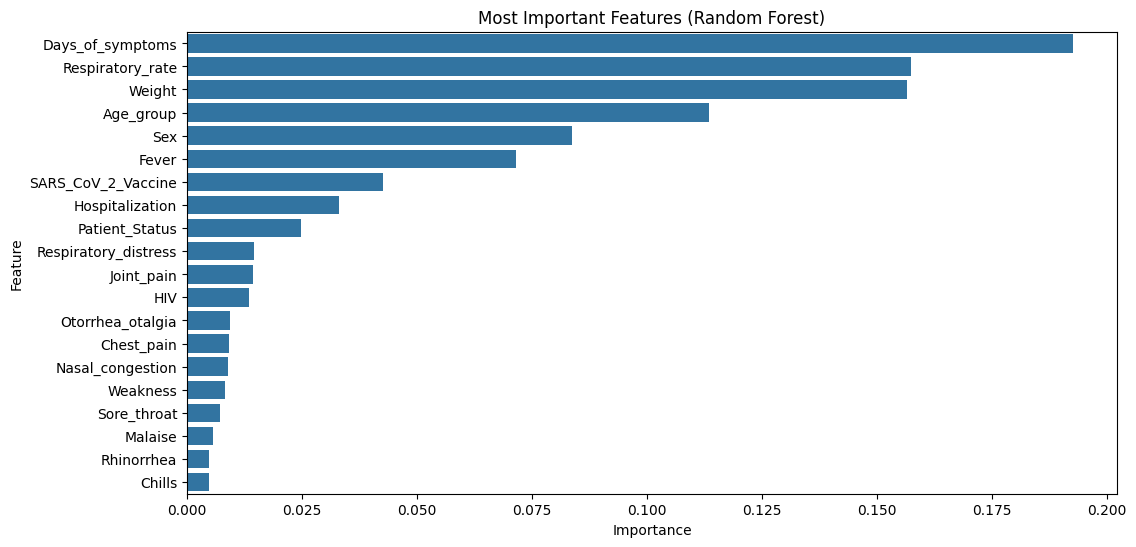


Selected Features - Random Forest: ['Days_of_symptoms', 'Respiratory_rate', 'Weight', 'Age_group', 'Sex', 'Fever', 'SARS_CoV_2_Vaccine', 'Hospitalization', 'Patient_Status', 'Respiratory_distress', 'Joint_pain', 'HIV', 'Otorrhea_otalgia', 'Chest_pain', 'Nasal_congestion', 'Weakness', 'Sore_throat', 'Malaise', 'Rhinorrhea', 'Chills']
Selected Features - LASSO (L1): ['Patient_Status', 'Age_group', 'Sex', 'Weight', 'SARS_CoV_2_Vaccine', 'Hospitalization', 'Days_of_symptoms', 'Fever', 'Respiratory_rate', 'Cough', 'Respiratory_distress', 'Myalgia', 'Chills', 'Sore_throat', 'Rhinorrhea', 'Otorrhea_otalgia', 'Nasal_congestion', 'Itching', 'Chest_pain', 'Weakness', 'Loss_of_taste', 'Joint_pain', 'Runny_nose', 'Abdominal_pain', 'Shortness_of_breathe', 'Malaise', 'Exanthema', 'Anorexia', 'Headache', 'Muscle_pain', 'Diabetes']
Selected Features - RFE: ['Patient_Status', 'Weight', 'SARS_CoV_2_Vaccine', 'Hospitalization', 'Days_of_symptoms', 'Fever', 'Respiratory_distress', 'Chills', 'Rhinorrhea',

In [42]:
# ====== Balancing with ADASYN ======
# adasyn = ADASYN(sampling_strategy=0.8, random_state=42)
# X_resampled, y_resampled = adasyn.fit_resample(X, y)

# ====== Balancing with SMOTE ENN ======
smote_enn = SMOTEENN(sampling_strategy=0.8, random_state=42)
X_resampled, y_resampled = smote_enn.fit_resample(X, y)

# ====== Data Standardization ======
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_resampled)

# ====== Feature Selection ======

## 1. Random Forest Feature Importance
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_resampled, y_resampled)

feature_importances = pd.DataFrame({'Feature': X.columns, 'Importance': rf.feature_importances_})
feature_importances = feature_importances.sort_values(by='Importance', ascending=False)

# Plot of the 20 most important variables
plt.figure(figsize=(12, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importances[:20])
plt.title('Most Important Features (Random Forest)')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

# Select the 20 most important variables
selected_features_rf = feature_importances[:20]['Feature'].tolist()

## 2. Feature Selection via LASSO (L1)
lasso = SelectFromModel(LogisticRegression(C=0.1, penalty='l1', solver='liblinear', max_iter=2000))
lasso.fit(X_scaled, y_resampled)
selected_features_lasso = X.columns[lasso.get_support()].tolist()

## 3. Feature Selection via Recursive Feature Elimination (RFE)
log_reg = LogisticRegression(max_iter=2000, solver='lbfgs')
rfe = RFE(log_reg, n_features_to_select=20)
rfe.fit(X_scaled, y_resampled)
selected_features_rfe = X.columns[rfe.support_].tolist()

# ====== Display Selected Features ======
print("\nSelected Features - Random Forest:", selected_features_rf)
print("Selected Features - LASSO (L1):", selected_features_lasso)
print("Selected Features - RFE:", selected_features_rfe)

# Define the final list of features as the intersection of the three methods
final_features = list(set(selected_features_rf) & set(selected_features_lasso) & set(selected_features_rfe))
print("\nFinal Selected Features:", final_features)

# Update X with only the best features
X_selected = X[final_features]



In [43]:
# Define target variable and features (NOW USING ONLY SELECTED FEATURES)
final_features = [
    'Days_of_symptoms', 'Weight', 'Fever', 'Respiratory_distress',
    'Patient_Status', 'Hospitalization', 'SARS_CoV_2_Vaccine',
    'Chest_pain', 'Weakness', 'Nasal_congestion', 'Rhinorrhea',
    'Otorrhea_otalgia', 'Chills'
]

X_selected = df[final_features]
y = df['resultado_sars_cov_2'].astype(int)

# Balancing with ADASYN (better than SMOTE)
# adasyn = ADASYN(sampling_strategy=0.75, random_state=42)
# X_resampled, y_resampled = adasyn.fit_resample(X_selected, y)

# Balancing with SMOTE ENN
smote_enn = SMOTEENN(sampling_strategy=0.8, random_state=42)
X_resampled, y_resampled = smote_enn.fit_resample(X_selected, y)

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X_resampled, y_resampled, test_size=0.2, stratify=y_resampled, random_state=42
)

# Cross-validation configuration
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Models tuned to reduce overfitting
models = {
    "Random Forest": RandomForestClassifier(bootstrap=False, n_estimators=200, max_depth=12,
                                            min_samples_split=5, min_samples_leaf=10, random_state=42),
    "Extra Trees (CFOREST)": ExtraTreesClassifier(n_estimators=200, max_depth=12,
                                                  min_samples_split=5, min_samples_leaf=10, random_state=42),
    "RANGER (RF)": RandomForestClassifier(n_estimators=200, max_depth=12, min_samples_split=5,
                                          min_samples_leaf=10, random_state=42),
    "MLP Classifier (NNET)": MLPClassifier(hidden_layer_sizes=(50,50), alpha=0.01, max_iter=1000,
                                           activation='relu', solver='adam', random_state=42),
    "SVM": SVC(kernel='rbf', C=10, gamma='auto', probability=True, random_state=42),
    "Logistic Regression": LogisticRegression(C=10, max_iter=500, penalty='l1',
                                              solver='liblinear', random_state=42),
    "XGBoost": XGBClassifier(n_estimators=200, learning_rate=0.05, max_depth=5,
                             gamma=0.1, reg_lambda=1, eval_metric='logloss', random_state=42),
    "Robust XGBoost": XGBClassifier(n_estimators=200, learning_rate=0.05, max_depth=5,
                                    gamma=0.1, reg_lambda=1, scale_pos_weight=2,
                                    eval_metric='logloss', random_state=42),
    "Decision Tree": DecisionTreeClassifier(criterion='entropy', max_depth=10,
                                            min_samples_split=5, min_samples_leaf=20, random_state=42)
}



Training model: Random Forest
=== Random Forest ===
Confusion Matrix (Test):
 [[2154  114]
 [ 325 1175]]
Classification Report (Test):
               precision    recall  f1-score   support

           0       0.87      0.95      0.91      2268
           1       0.91      0.78      0.84      1500

    accuracy                           0.88      3768
   macro avg       0.89      0.87      0.88      3768
weighted avg       0.89      0.88      0.88      3768

ROC AUC (Test): 0.9602


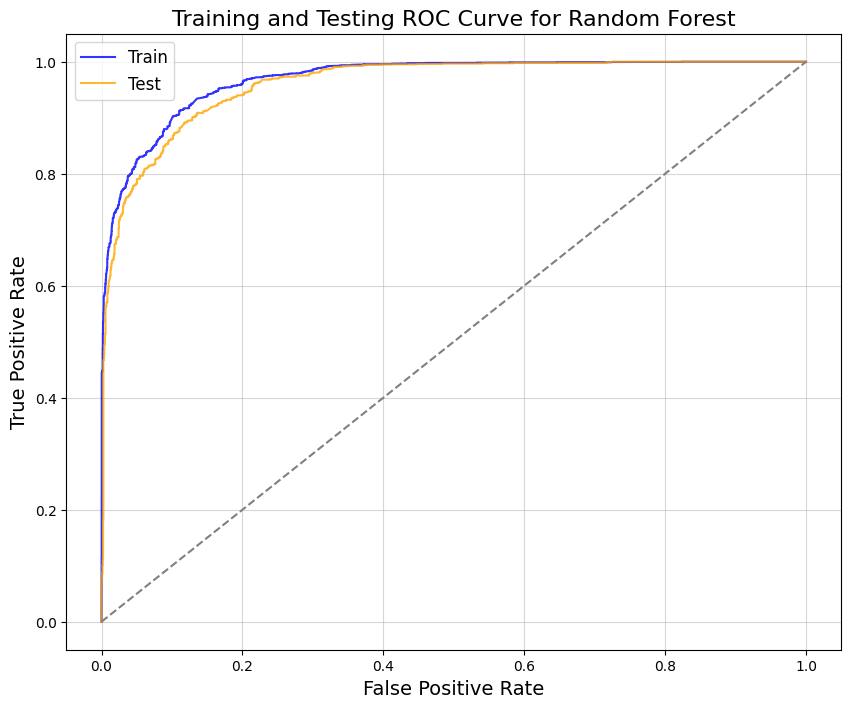


Training model: Extra Trees (CFOREST)
=== Extra Trees (CFOREST) ===
Confusion Matrix (Test):
 [[2140  128]
 [ 758  742]]
Classification Report (Test):
               precision    recall  f1-score   support

           0       0.74      0.94      0.83      2268
           1       0.85      0.49      0.63      1500

    accuracy                           0.76      3768
   macro avg       0.80      0.72      0.73      3768
weighted avg       0.78      0.76      0.75      3768

ROC AUC (Test): 0.8602


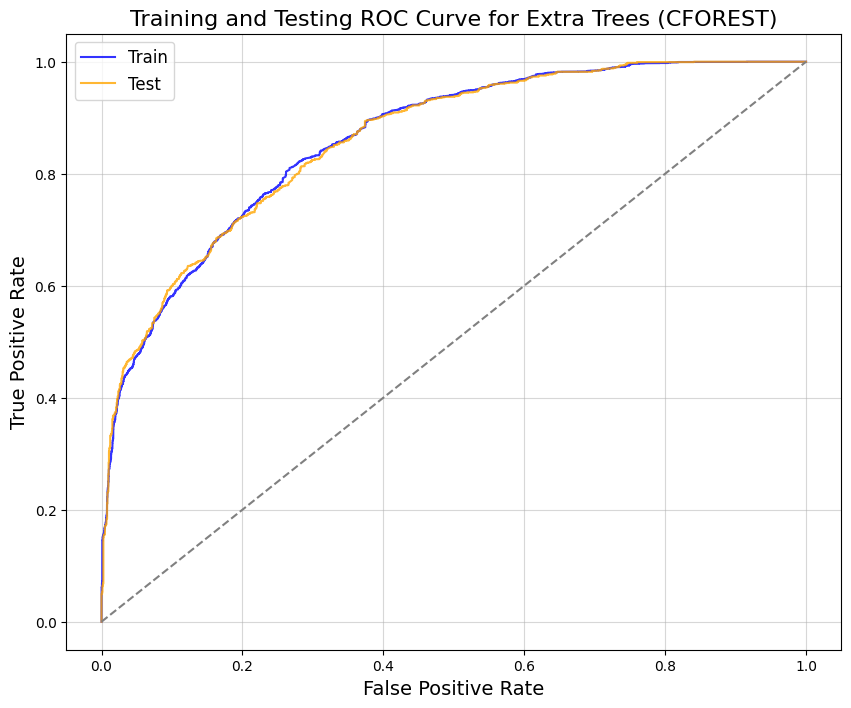


Training model: RANGER (RF)
=== RANGER (RF) ===
Confusion Matrix (Test):
 [[2141  127]
 [ 339 1161]]
Classification Report (Test):
               precision    recall  f1-score   support

           0       0.86      0.94      0.90      2268
           1       0.90      0.77      0.83      1500

    accuracy                           0.88      3768
   macro avg       0.88      0.86      0.87      3768
weighted avg       0.88      0.88      0.87      3768

ROC AUC (Test): 0.9533


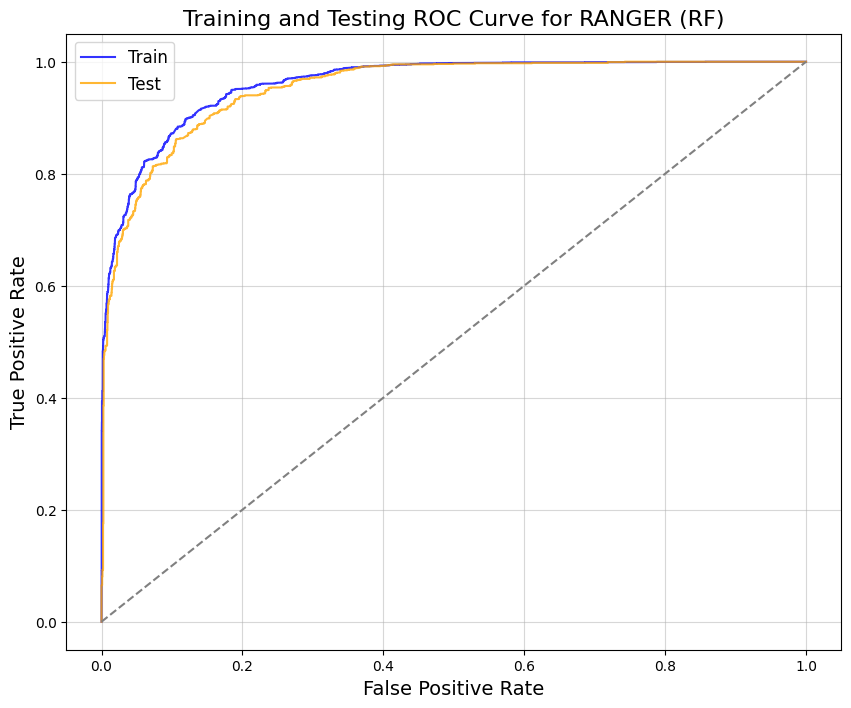


Training model: MLP Classifier (NNET)
=== MLP Classifier (NNET) ===
Confusion Matrix (Test):
 [[2027  241]
 [ 292 1208]]
Classification Report (Test):
               precision    recall  f1-score   support

           0       0.87      0.89      0.88      2268
           1       0.83      0.81      0.82      1500

    accuracy                           0.86      3768
   macro avg       0.85      0.85      0.85      3768
weighted avg       0.86      0.86      0.86      3768

ROC AUC (Test): 0.9457


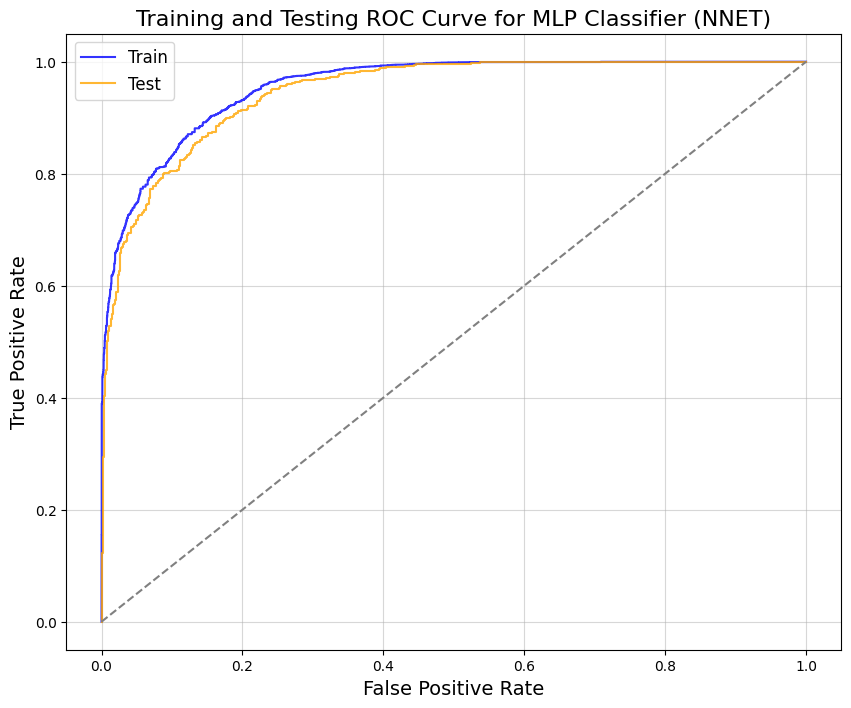


Training model: SVM
=== SVM ===
Confusion Matrix (Test):
 [[2036  232]
 [ 608  892]]
Classification Report (Test):
               precision    recall  f1-score   support

           0       0.77      0.90      0.83      2268
           1       0.79      0.59      0.68      1500

    accuracy                           0.78      3768
   macro avg       0.78      0.75      0.75      3768
weighted avg       0.78      0.78      0.77      3768

ROC AUC (Test): 0.8434


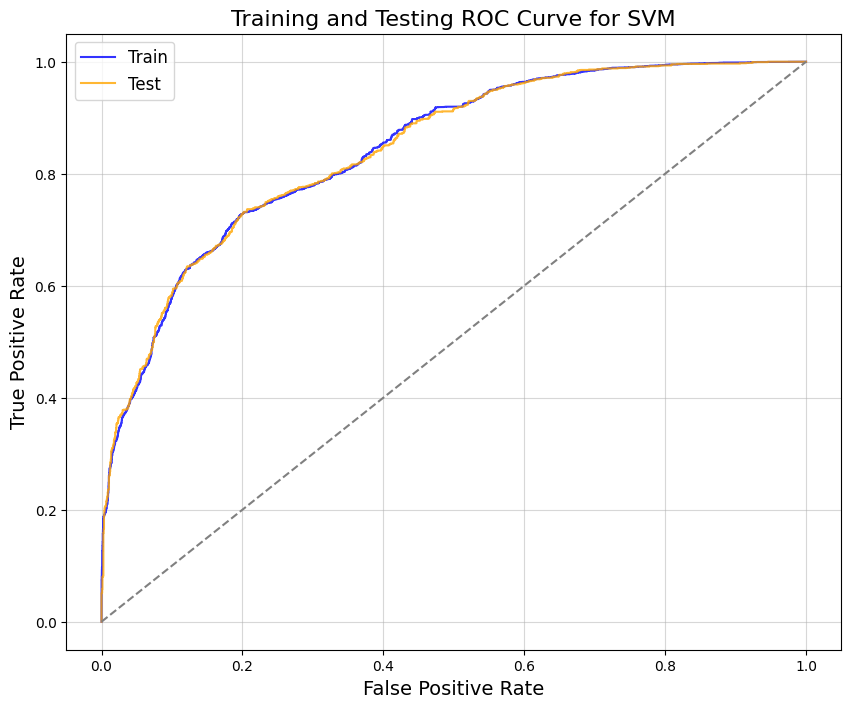


Training model: Logistic Regression
=== Logistic Regression ===
Confusion Matrix (Test):
 [[1960  308]
 [ 928  572]]
Classification Report (Test):
               precision    recall  f1-score   support

           0       0.68      0.86      0.76      2268
           1       0.65      0.38      0.48      1500

    accuracy                           0.67      3768
   macro avg       0.66      0.62      0.62      3768
weighted avg       0.67      0.67      0.65      3768

ROC AUC (Test): 0.6934


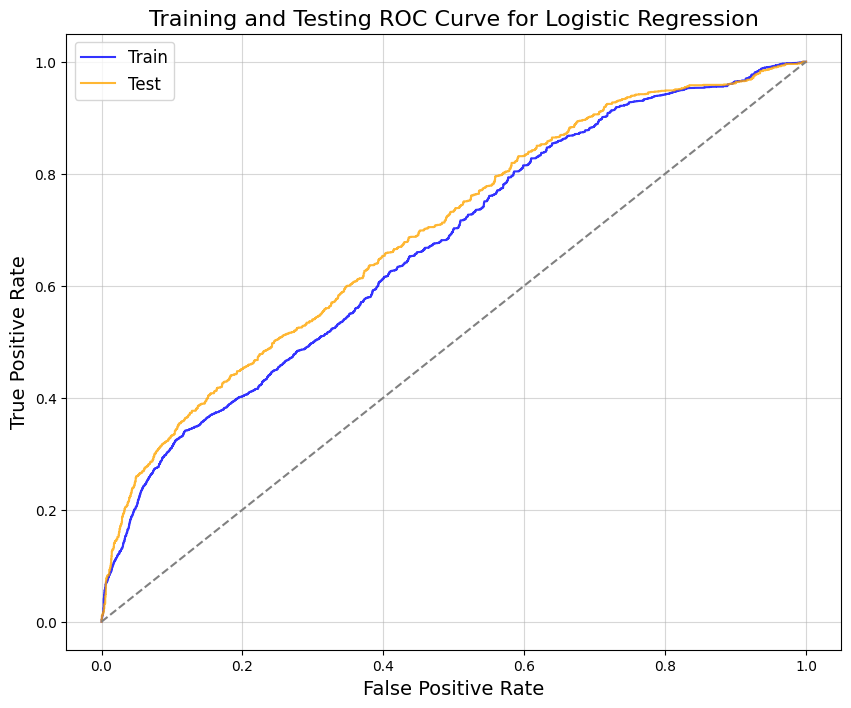


Training model: XGBoost
=== XGBoost ===
Confusion Matrix (Test):
 [[2227   41]
 [ 211 1289]]
Classification Report (Test):
               precision    recall  f1-score   support

           0       0.91      0.98      0.95      2268
           1       0.97      0.86      0.91      1500

    accuracy                           0.93      3768
   macro avg       0.94      0.92      0.93      3768
weighted avg       0.94      0.93      0.93      3768

ROC AUC (Test): 0.9781


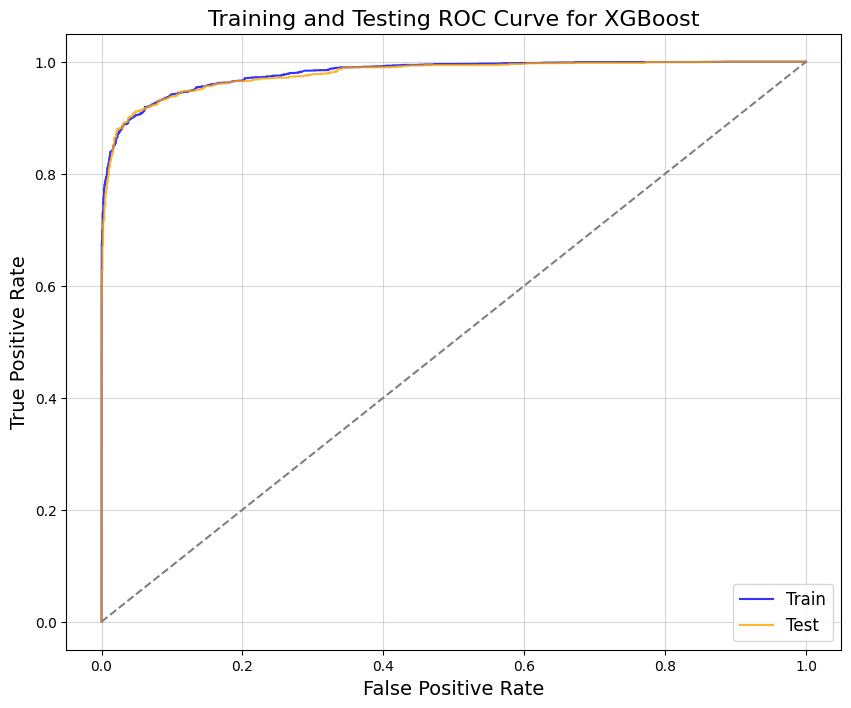


Training model: Robust XGBoost
=== Robust XGBoost ===
Confusion Matrix (Test):
 [[2077  191]
 [ 105 1395]]
Classification Report (Test):
               precision    recall  f1-score   support

           0       0.95      0.92      0.93      2268
           1       0.88      0.93      0.90      1500

    accuracy                           0.92      3768
   macro avg       0.92      0.92      0.92      3768
weighted avg       0.92      0.92      0.92      3768

ROC AUC (Test): 0.9789


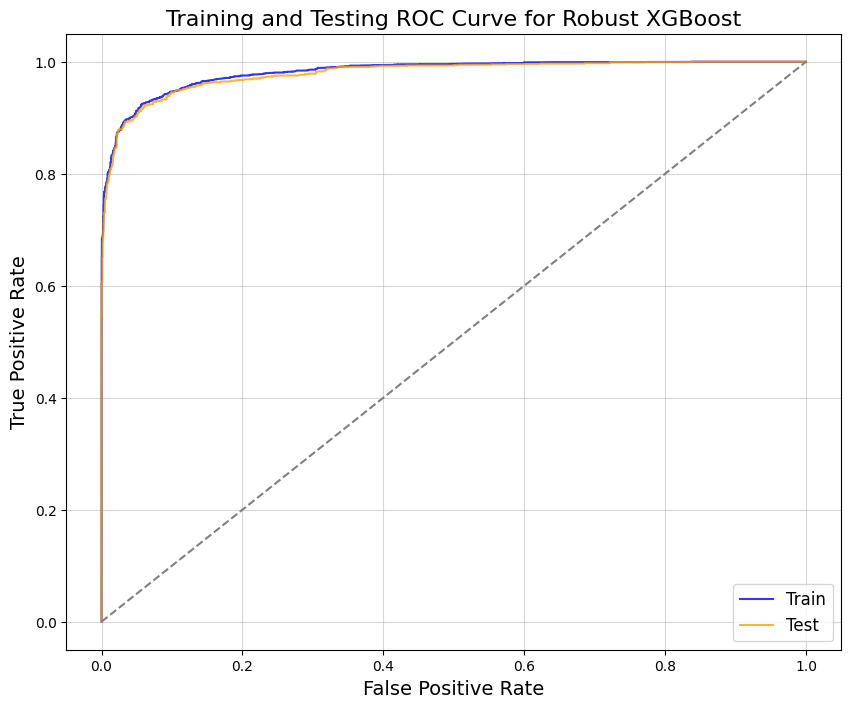


Training model: Decision Tree
=== Decision Tree ===
Confusion Matrix (Test):
 [[2040  228]
 [ 505  995]]
Classification Report (Test):
               precision    recall  f1-score   support

           0       0.80      0.90      0.85      2268
           1       0.81      0.66      0.73      1500

    accuracy                           0.81      3768
   macro avg       0.81      0.78      0.79      3768
weighted avg       0.81      0.81      0.80      3768

ROC AUC (Test): 0.8975


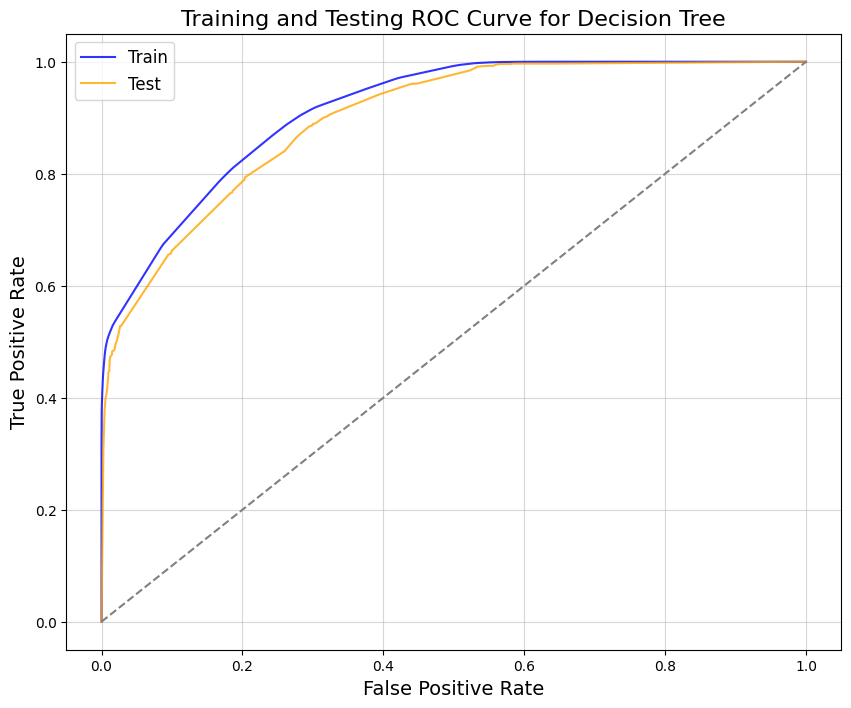

In [44]:
results = []

for name, model in models.items():
    print(f"\nTraining model: {name}")
    
    model.fit(X_train, y_train)
    y_train_pred = model.predict(X_train)
    y_test_pred  = model.predict(X_test)

    if hasattr(model, "predict_proba"):
        y_train_pred_proba = model.predict_proba(X_train)[:, 1]
        y_test_pred_proba  = model.predict_proba(X_test)[:, 1]
    else:
        y_train_pred_proba = y_train_pred
        y_test_pred_proba  = y_test_pred

    print(f"=== {name} ===")
    print("Confusion Matrix (Test):\n", confusion_matrix(y_test, y_test_pred))
    print("Classification Report (Test):\n", classification_report(y_test, y_test_pred))
    roc_auc_test = roc_auc_score(y_test, y_test_pred_proba)
    print(f"ROC AUC (Test): {roc_auc_test:.4f}")

    y_test_np = y_test.to_numpy()
    y_test_pred_np = np.array(y_test_pred)
    y_test_pred_proba_np = np.array(y_test_pred_proba)

    # IC: Acurácia
    acc, acc_l, acc_u = bootstrap_metric_confidence_interval(
        y_test_np, y_test_pred_np, accuracy_score, 2000, 0.05, 42)

    # IC: AUROC
    auc, auc_l, auc_u = bootstrap_metric_confidence_interval(
        y_test_np, y_test_pred_proba_np, roc_auc_score, 2000, 0.05, 42)

    # IC: Sensibilidade
    sens, sens_l, sens_u = bootstrap_metric_confidence_interval(
        y_test_np, y_test_pred_np,
        lambda y, y_pred: recall_score(y, y_pred, pos_label=1), 2000, 0.05, 42)

    # IC: Especificidade
    spec, spec_l, spec_u = bootstrap_metric_confidence_interval(
        y_test_np, y_test_pred_np,
        lambda y, y_pred: recall_score(y, y_pred, pos_label=0), 2000, 0.05, 42)

    # IC: Precisão
    prec, prec_l, prec_u = bootstrap_metric_confidence_interval(
        y_test_np, y_test_pred_np, precision_score, 2000, 0.05, 42)

    # IC: F1-score
    f1, f1_l, f1_u = bootstrap_metric_confidence_interval(
        y_test_np, y_test_pred_np, f1_score, 2000, 0.05, 42)

    # Guardar resultados
    results.append({
        "Model": name,
        "Accuracy (Test)": round(acc, 3),
        "95% CI (Accuracy)": f"({acc_l:.3f}, {acc_u:.3f})",
        "AUROC (Test)": round(auc, 3),
        "95% CI (AUROC)": f"({auc_l:.3f}, {auc_u:.3f})",
        "Sensitivity": round(sens, 3),
        "95% CI (Sensitivity)": f"({sens_l:.3f}, {sens_u:.3f})",
        "Specificity": round(spec, 3),
        "95% CI (Specificity)": f"({spec_l:.3f}, {spec_u:.3f})",
        "Precision": round(prec, 3),
        "95% CI (Precision)": f"({prec_l:.3f}, {prec_u:.3f})",
        "F1-score": round(f1, 3),
        "95% CI (F1-score)": f"({f1_l:.3f}, {f1_u:.3f})"
    })

    # Curva ROC
    fpr_train, tpr_train, _ = roc_curve(y_train, y_train_pred_proba)
    fpr_test,  tpr_test,  _ = roc_curve(y_test,  y_test_pred_proba)

    plt.figure(figsize=(10, 8))
    plt.plot(fpr_train, tpr_train, linestyle='-', label='Train', color='blue', alpha=0.8)
    plt.plot(fpr_test,  tpr_test,  linestyle='-', label='Test', color='orange', alpha=0.8)
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
    plt.xlabel('False Positive Rate', fontsize=14)
    plt.ylabel('True Positive Rate', fontsize=14)
    plt.title(f'Training and Testing ROC Curve for {name}', fontsize=16)
    plt.legend(fontsize=12)
    plt.grid(alpha=0.5)
    plt.show()

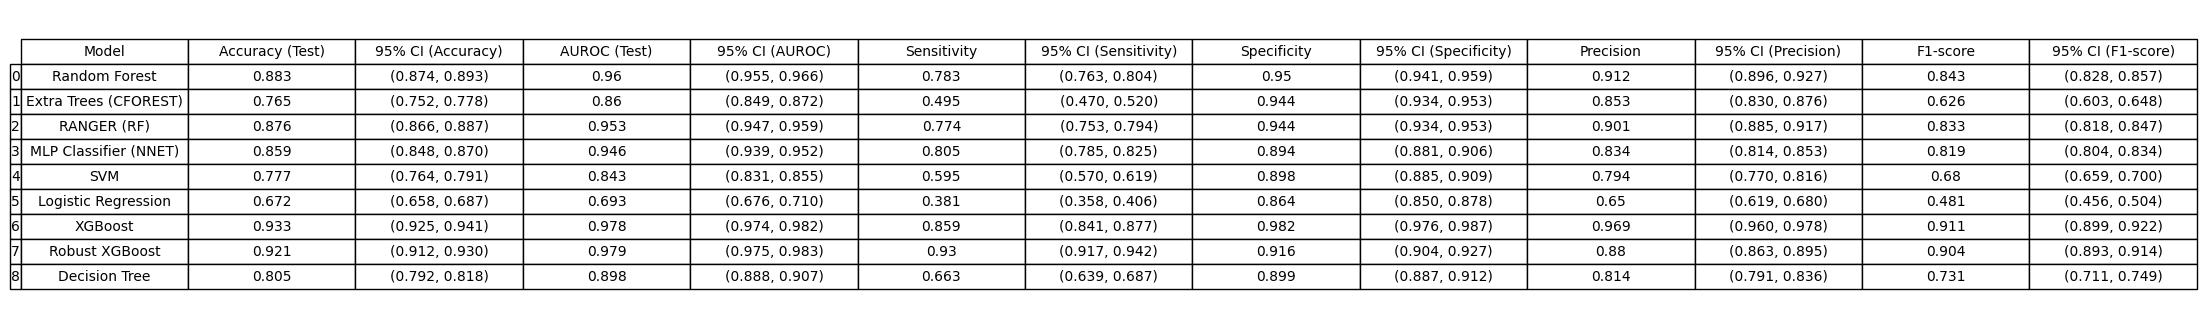

In [45]:
# Converter resultados para DataFrame
df_results = pd.DataFrame(results)

# Exportar para Excel ou PDF
df_results.to_excel("sars_models_metrics_results.xlsx", index=False)

# Criar imagem da tabela em PDF
fig, ax = plt.subplots(figsize=(12, 4))
ax.axis('off')
tbl = table(ax, df_results.round(3), loc='center', cellLoc='center', colWidths=[0.15]*len(df_results.columns))
tbl.auto_set_font_size(False)
tbl.set_fontsize(10)
tbl.scale(1.2, 1.5)

# Guardar como PDF
plt.savefig("sars_models_metrics_results_.pdf", bbox_inches='tight')


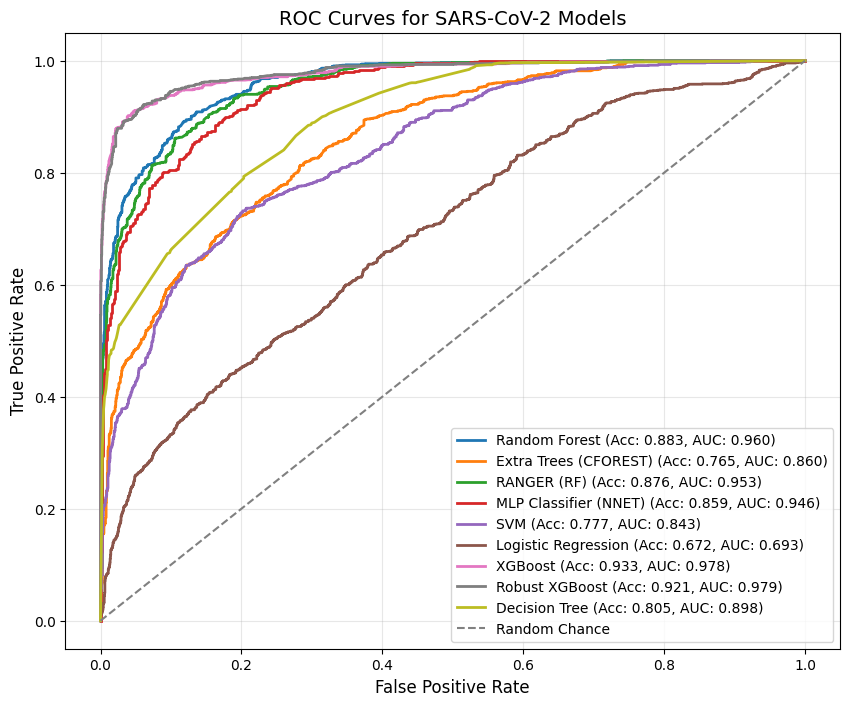

Random Forest: Accuracy = 0.883, AUROC = 0.960
Extra Trees (CFOREST): Accuracy = 0.765, AUROC = 0.860
RANGER (RF): Accuracy = 0.876, AUROC = 0.953
MLP Classifier (NNET): Accuracy = 0.859, AUROC = 0.946
SVM: Accuracy = 0.777, AUROC = 0.843
Logistic Regression: Accuracy = 0.672, AUROC = 0.693
XGBoost: Accuracy = 0.933, AUROC = 0.978
Robust XGBoost: Accuracy = 0.921, AUROC = 0.979
Decision Tree: Accuracy = 0.805, AUROC = 0.898


In [46]:
# Dictionary to store metrics for each model
metrics = {}

plt.figure(figsize=(10, 8))

# Loop through each model in the dictionary
for name, model in models.items():
    # Train the model
    model.fit(X_train, y_train)
    
    # Make predictions on the test set
    y_test_pred = model.predict(X_test)
    
    # Get predicted probabilities if available (for ROC calculation)
    if hasattr(model, "predict_proba"):
        y_test_pred_proba = model.predict_proba(X_test)[:, 1]
    else:
        # Fallback if predict_proba is not available
        y_test_pred_proba = y_test_pred
    
    # Calculate ROC curve and AUROC score
    fpr, tpr, _ = roc_curve(y_test, y_test_pred_proba)
    auc_score = roc_auc_score(y_test, y_test_pred_proba)
    acc = accuracy_score(y_test, y_test_pred)
    
    # Store the metrics in the dictionary
    metrics[name] = (acc, auc_score)
    
    # Plot the ROC curve for the model with its metrics in the label
    plt.plot(fpr, tpr, lw=2, label=f"{name} (Acc: {acc:.3f}, AUC: {auc_score:.3f})")

# Plot the diagonal (random chance)
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label="Random Chance")

# Customize the plot
plt.xlabel("False Positive Rate", fontsize=12)
plt.ylabel("True Positive Rate", fontsize=12)
plt.title("ROC Curves for SARS-CoV-2 Models", fontsize=14)
plt.legend(loc="lower right", fontsize=10)
plt.grid(alpha=0.3)
plt.show()

# Optionally, print the metrics for each model
for name, (acc, auc_score) in metrics.items():
    print(f"{name}: Accuracy = {acc:.3f}, AUROC = {auc_score:.3f}")


<Axes: title={'center': 'Feature importance'}, xlabel='Importance score', ylabel='Features'>

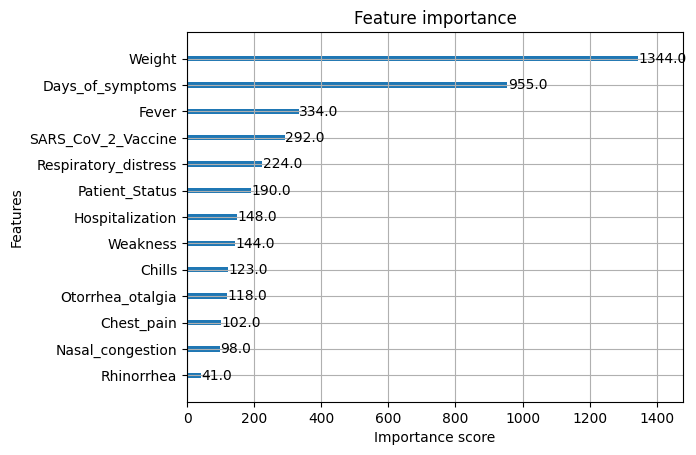

In [47]:
import xgboost as xgb
# Train the model
models["XGBoost"].fit(X_train, y_train)
xgb.plot_importance(models["XGBoost"])

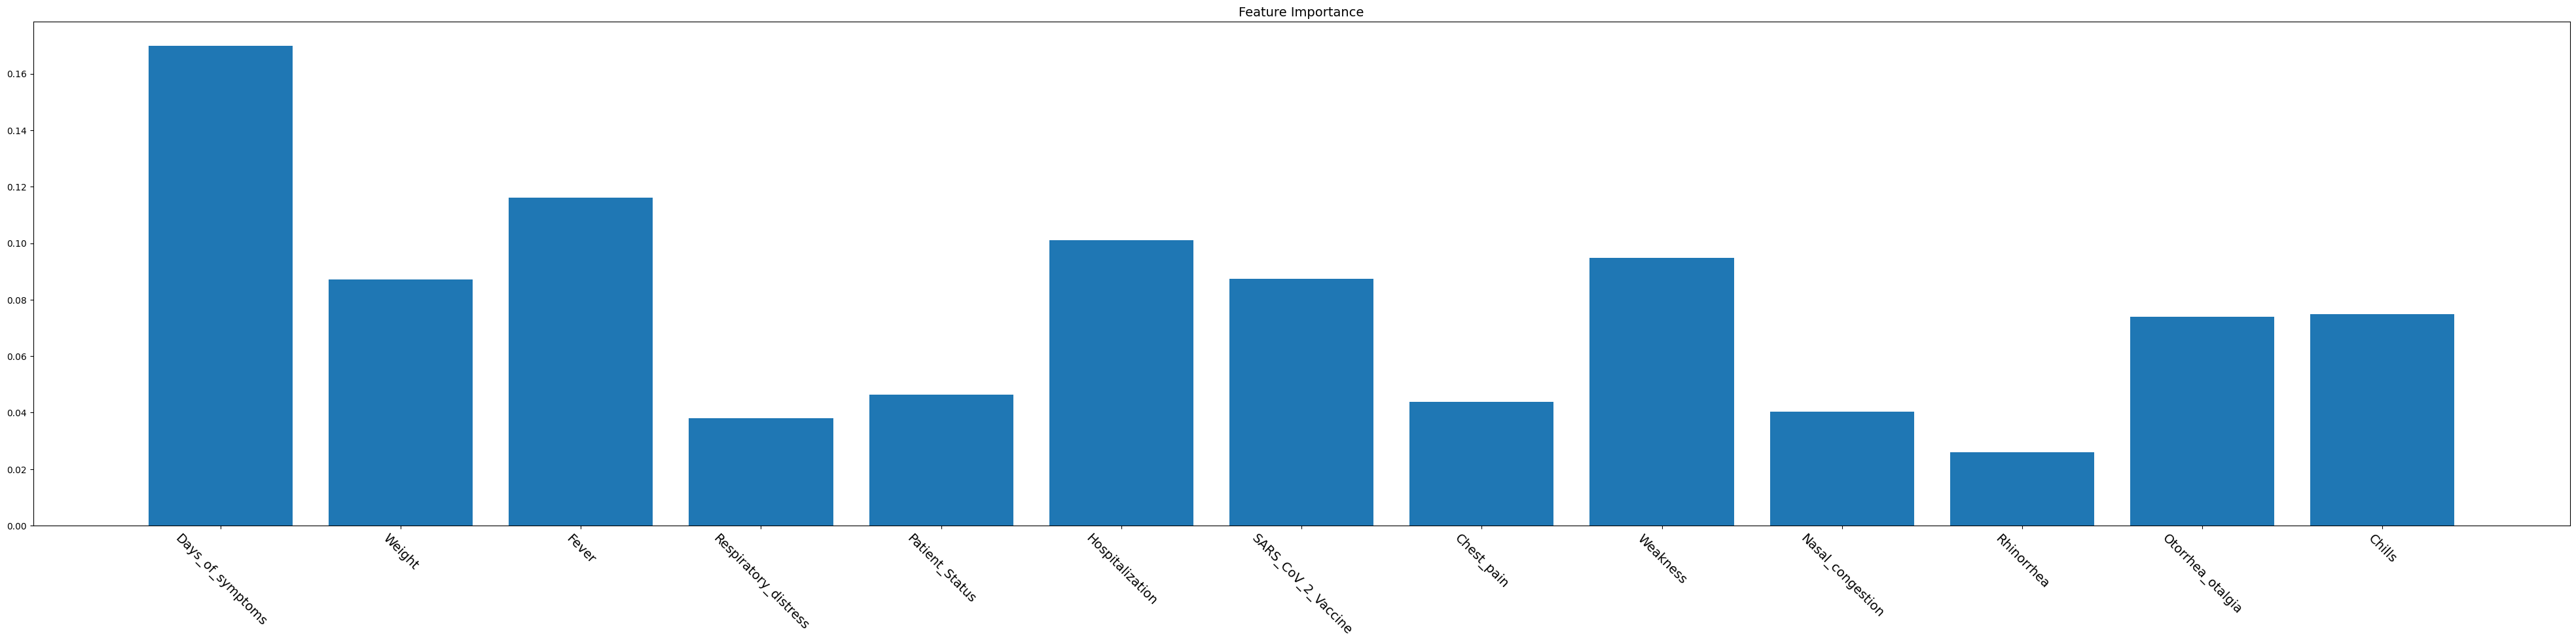

In [48]:
# Plot the important features
plt.figure(figsize=(50, 10))
plt.bar(range(len(X_train.columns)), models["XGBoost"].feature_importances_)
plt.xticks(range(len(X_train.columns)), X_train.columns, rotation=-45, fontsize=14)
plt.title('Feature Importance', fontsize=14)
plt.show()

Shape of SHAP values: (15068, 13)


/tmp/ipykernel_34445/706077079.py:12: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X_train)


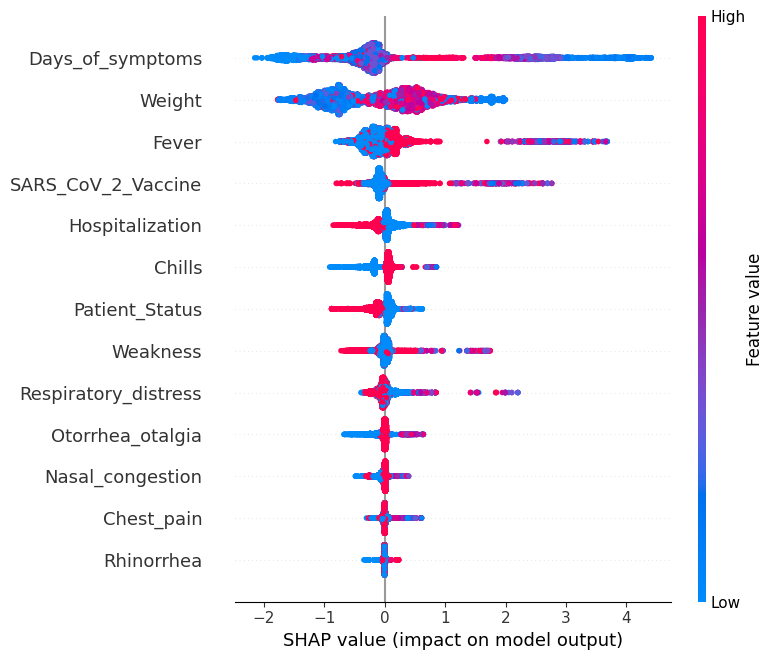

/tmp/ipykernel_34445/706077079.py:15: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X_train, plot_type="bar")


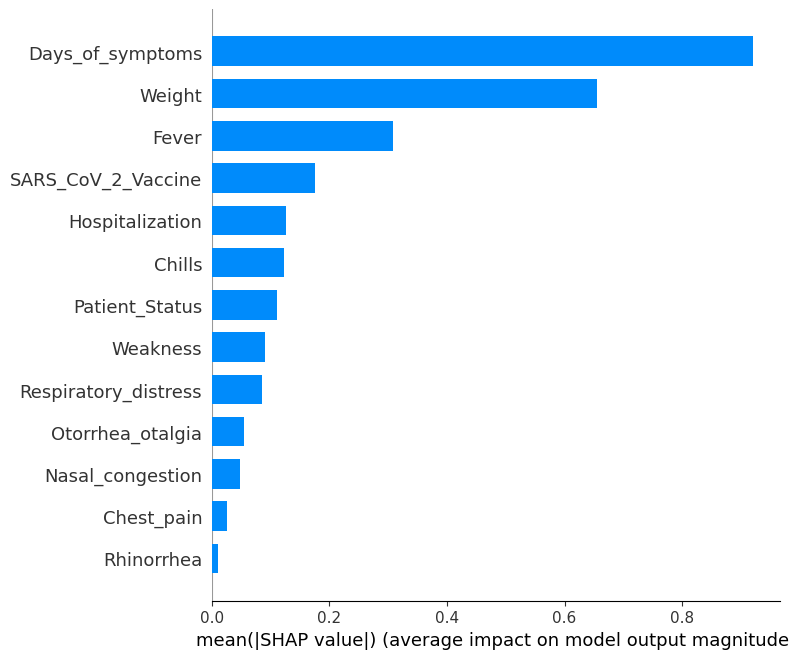

<Figure size 640x480 with 0 Axes>

In [49]:
import shap
# Initialize SHAP explainer for the best XGBoost model
explainer = shap.TreeExplainer(models["XGBoost"])

# Calculate SHAP values for the training dataset
shap_values = explainer.shap_values(X_train)

# Check the shape of SHAP values
print("Shape of SHAP values:", shap_values.shape)

# SHAP summary plot
shap.summary_plot(shap_values, X_train)

# SHAP bar summary plot for average feature importance
shap.summary_plot(shap_values, X_train, plot_type="bar")

# SHAP force plot for detailed visualization
# Using the average expected values and shap_values from the training set
# Visualizing only the first 100 observations to avoid overload
shap.force_plot(explainer.expected_value, shap_values[:100], X_train[:100])

# Save the SHAP force plot as an image
plt.savefig('shap_force_plot.png', dpi=400)



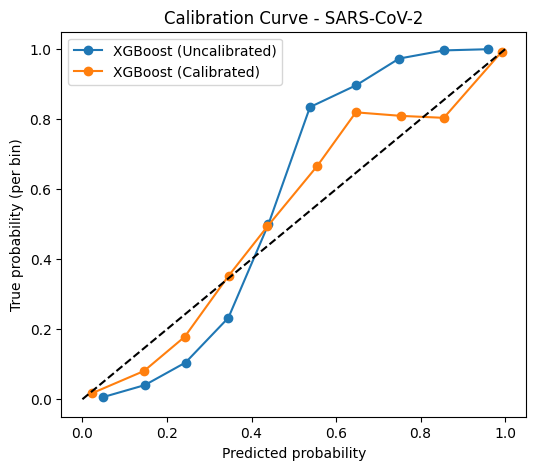

In [50]:
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
import matplotlib.lines as mlines
import matplotlib.transforms as mtransforms

# Get probability predictions before calibration
y_test_pred_proba = models["XGBoost"].predict_proba(X_test)[:, 1]

# Calculate calibration curve before calibration
prob_true, prob_pred = calibration_curve(y_test, y_test_pred_proba, n_bins=10)

# Apply calibration using isotonic regression
xgb_calibrated = CalibratedClassifierCV(models["XGBoost"], method='isotonic', cv=10)
xgb_calibrated.fit(X_train, y_train)

# Get new probability predictions after calibration
y_test_pred_proba_calibrated = xgb_calibrated.predict_proba(X_test)[:, 1]

# Recalculate calibration curve after calibration
prob_true_calibrated, prob_pred_calibrated = calibration_curve(y_test, y_test_pred_proba_calibrated, n_bins=10)

# Plot calibration curves comparing before and after calibration
plt.figure(figsize=(6, 5))
plt.plot(prob_pred, prob_true, marker='o', label="XGBoost (Uncalibrated)")
plt.plot(prob_pred_calibrated, prob_true_calibrated, marker='o', label="XGBoost (Calibrated)")
plt.plot([0, 1], [0, 1], linestyle='--', color='black')  # Ideal reference line
plt.xlabel("Predicted probability")
plt.ylabel("True probability (per bin)")
plt.legend()
plt.title("Calibration Curve - SARS-CoV-2")
plt.show()


In [51]:
from sklearn.metrics import brier_score_loss, log_loss

y_test_pred_proba = xgb_calibrated.predict_proba(X_test)[:, 1]

# Calculate Brier Score
brier = brier_score_loss(y_test, y_test_pred_proba)
print("Brier Score:", brier)

# Calculate Log-Loss
# For binary classification, just pass y_test and predicted probabilities for the positive class
logloss = log_loss(y_test, y_test_pred_proba)
print("Log-Loss:", logloss)


Brier Score: 0.046440878288712344
Log-Loss: 0.16212006737561685


In [52]:
import joblib

# Save the calibrated model
joblib.dump(xgb_calibrated, 'modelo_calibrado_sars.pkl')
print("Modelo calibrado salvo com sucesso!")


Modelo calibrado salvo com sucesso!
